# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Correct import for date formatting


# Import Data

In [2]:
# Define the ticker symbol for Bitcoin
ticker = 'BTC-USD'

# Get historical market data
bitcoindf = yf.Ticker(ticker).history(period="max")

# Making the 'Date' as the index
bitcoindf.index = pd.to_datetime(bitcoindf.index)

# Drop the "Dividends" column and "Stock Splits" column
bitcoindf.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Print the data
print(bitcoindf.tail())

                                   Open          High           Low  \
Date                                                                  
2024-05-24 00:00:00+00:00  67928.132812  69220.296875  66622.671875   
2024-05-25 00:00:00+00:00  68526.921875  69579.320312  68515.820312   
2024-05-26 00:00:00+00:00  69264.289062  69506.226562  68183.890625   
2024-05-27 00:00:00+00:00  68512.179688  70597.882812  68232.500000   
2024-05-29 00:00:00+00:00  68323.023438  68848.156250  68293.085938   

                                  Close       Volume  
Date                                                  
2024-05-24 00:00:00+00:00  68526.101562  29197308153  
2024-05-25 00:00:00+00:00  69265.945312  15473071741  
2024-05-26 00:00:00+00:00  68518.093750  15628433737  
2024-05-27 00:00:00+00:00  69394.554688  25870990717  
2024-05-29 00:00:00+00:00  68797.226562  29925109760  


# Preprocessing

In [3]:
# Print column names to identify the correct date column name
print(bitcoindf.columns)

# Display the first few rows with styled close column, using the index for dates
bitcoindf.tail().style.set_properties(subset=['Close'])

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Volume
Date,,,,,
2024-05-24 00:00:00+00:00,67928.132812,69220.296875,66622.671875,68526.101562,29197308153
2024-05-25 00:00:00+00:00,68526.921875,69579.320312,68515.820312,69265.945312,15473071741
2024-05-26 00:00:00+00:00,69264.289062,69506.226562,68183.890625,68518.093750,15628433737
2024-05-27 00:00:00+00:00,68512.179688,70597.882812,68232.500000,69394.554688,25870990717
2024-05-29 00:00:00+00:00,68323.023438,68848.156250,68293.085938,68797.226562,29925109760


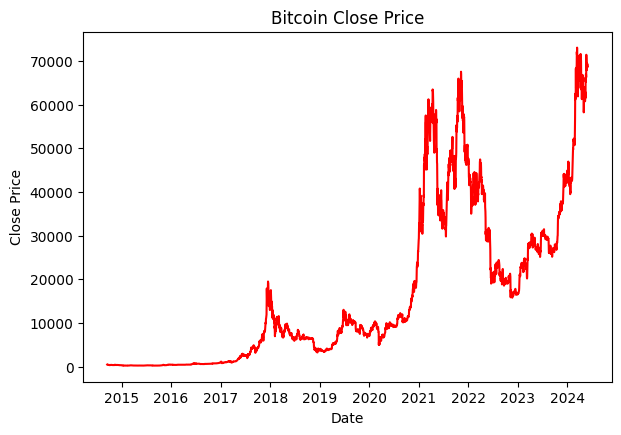

In [4]:
# Plot the Bitcoin Close Price
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(bitcoindf.index, bitcoindf['Close'], color="red")
plt.title('Bitcoin Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')

plt.show()

# Dataframe of bitcoin close price

In [5]:
# Create a DataFrame of Bitcoin close prices
closedf = bitcoindf[['Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (3542, 1)


In [6]:
# Ensure date is in the index and filter the data from a specific date
closedf = bitcoindf[['Close']]
closedf = closedf[closedf.index > '2021-04-13']
close_stock = closedf.copy()
print("Total data for prediction: ", closedf.shape[0])

Total data for prediction:  1141


In [7]:
# Normalize the 'Close' price values
scaler = MinMaxScaler(feature_range=(0, 1))
closedf['Close'] = scaler.fit_transform(np.array(closedf['Close']).reshape(-1, 1))

# Print the shape of the normalized data
print(closedf.shape)


(1141, 1)


In [8]:
# Separate data into training and testing datasets
training_size = int(len(closedf) * 0.70)
test_size = len(closedf) - training_size
train_data, test_data = closedf[:training_size], closedf[training_size:]

print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)

train_data shape:  (798, 1)
test_data shape:  (343, 1)


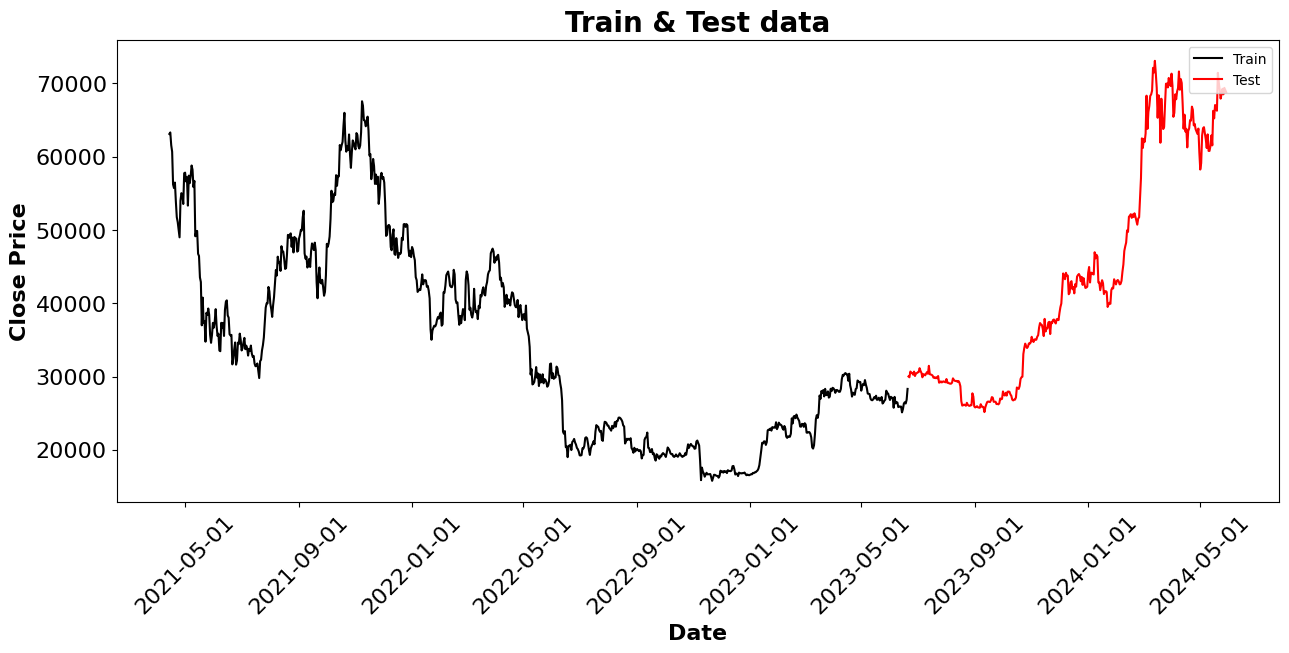

In [9]:
# Plotting Train and Test Data
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x=close_stock.index[:training_size], y=close_stock['Close'][:training_size], color='black', label='Train')
sns.lineplot(x=close_stock.index[training_size:], y=close_stock['Close'][training_size:], color='red', label='Test')

# Formatting
ax.set_title('Train & Test data', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Close Price', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right')

# Improve date formatting on x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

In [10]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]   # i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 15
pred_days = 1  # Number of days you want to predict

X_train, y_train = create_dataset(train_data.values, time_step)
X_test, y_test = create_dataset(test_data.values, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (782, 15)
y_train:  (782,)
X_test:  (327, 15)
y_test:  (327,)


In [11]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Make predictions
predictions = my_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mean_squared_error(y_test, predictions))

print("Mean Absolute Error - MAE : " + str(mae))
print("Root Mean Squared Error - RMSE : " + str(rmse))

Mean Absolute Error - MAE : 0.03497433925620875
Root Mean Squared Error - RMSE : 0.059033256543885436


In [13]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (782, 1)
Test data prediction: (327, 1)


In [14]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

# Shift train predictions for plotting
look_back = time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(closedf) - 1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])

plotdf = pd.DataFrame({
    'date': close_stock.index,
    'original_close': close_stock['Close'],
    'train_predicted_close': trainPredictPlot.reshape(-1),
    'test_predicted_close': testPredictPlot.reshape(-1)
})

fig = px.line(plotdf, x='date', y=['original_close', 'train_predicted_close', 'test_predicted_close'],
              labels={'value': 'Close price', 'date': 'Date'})
fig.update_layout(title_text='Comparison between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1141, 1)
Test predicted data:  (1141, 1)


In [15]:
# Generate arrays for the last days of the training period and the days to be predicted
last_days = np.arange(1, time_step + 1)
day_pred = np.arange(time_step + 1, time_step + pred_days + 1)

print("Last days array:", last_days)
print("Days to be predicted array:", day_pred)

Last days array: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Days to be predicted array: [16]


In [16]:
# Prepare for next prediction
lst_output = my_model.predict(X_test[-time_step:]).tolist()

# Initialize temp_mat for plotting
temp_mat = np.empty((len(last_days) + pred_days + 1, 1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1, -1).tolist()[0]

last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

# Populate temp_mat with actual last 15 days data and predicted next 10 days data
last_original_days_value[0:time_step] = scaler.inverse_transform(closedf[len(closedf) - time_step:].values).reshape(1, -1).tolist()[0]
next_predicted_days_value[time_step:] = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).reshape(1, -1).tolist()[0]

# Truncate both lists to the same length
min_length = min(len(last_original_days_value), len(next_predicted_days_value))
last_original_days_value = last_original_days_value[:min_length]
next_predicted_days_value = next_predicted_days_value[:min_length]

# Create DataFrame for new predictions
new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

names = cycle(['Last 15 days close price', "Tomorrow's close price"])

fig = px.line(new_pred_plot, x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                       new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price', 'index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs Tomorrow',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
